In [5]:
import jax
import time
import pypomp
import unittest
import tracemalloc
import jax.numpy as np
import numpy as onp
import pandas as pd

import pykalman
import seaborn as sns
import matplotlib.pyplot as plt
import jax.scipy.special

from tqdm import tqdm
from pypomp.mop import mop
from pypomp.pfilter import pfilter
from pypomp.fit import fit
from pypomp.internal_functions import _mop_internal
from pypomp.internal_functions import _pfilter_internal
from pypomp.internal_functions import _pfilter_internal_mean
from pypomp.internal_functions import _fit_internal
from pypomp.internal_functions import _perfilter_internal




### Test the Linear Gaussian Model: A comparison with Kalman-filtering algorithm

Model Setup

Kalman filter deals with the dynamic system:
\begin{align}
    x_t &= A x_{t-1} + w_t \\
    \text{where} \quad
    x_t &\text{ is the current state vector.} \nonumber \\
    A &\text{ is the state transition matrix.} \nonumber \\
    w_t &\sim \mathcal{N}(0, Q) \text{ is the process noise, normally distributed with mean 0 and covariance } Q. \nonumber \\
    y_t &= C x_t + v_t \\
    \text{where} \quad
    y_t &\text{ is the current observation vector.} \nonumber \\
    C &\text{ is the observation matrix.} \nonumber \\
    v_t &\sim \mathcal{N}(0, R) \text{ is the observation noise, normally distributed with mean 0 and covariance} R. \nonumber
\end{align}


(1) Set T (Time Length) to be 1000 and generate linear Gaussian states and observations:

In [6]:
def get_thetas(theta):
    A = theta[0:4].reshape(2, 2)
    C = theta[4:8].reshape(2, 2)
    Q = theta[8:12].reshape(2, 2)
    R = theta[12:16].reshape(2, 2)
    return A, C, Q, R

def transform_thetas(A, C, Q, R):
    return np.concatenate([A.flatten(), C.flatten(), Q.flatten(), R.flatten()])


fixed = False
key = jax.random.PRNGKey(111)
angle = 0.2
angle2 = angle if fixed else -0.5
A = np.array([[np.cos(angle2), -np.sin(angle)],
             [np.sin(angle), np.cos(angle2)]])
C = np.eye(2)
Q = np.array([[1, 1e-4],
             [1e-4, 1]]) # 100
R = np.array([[1, .1],
            [.1, 1]]) #/ 10
     
theta = transform_thetas(A, C, Q, R)

def generate_data(N, key):
    xs = []
    ys = []
    x = np.ones(2)
    for i in tqdm(range(N)):
        key, subkey = jax.random.split(key)
        x = jax.random.multivariate_normal(key=subkey, mean=A @ x, cov=Q)
        key, subkey = jax.random.split(key)
        y = jax.random.multivariate_normal(key=subkey, mean=C @ x, cov=R)
        xs.append(x)
        ys.append(y)
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys, key

def custom_rinit(theta, J, covars=None):
    return np.ones((J, 2))

def custom_rproc(state, theta, key, covars=None):
    A, C, Q, R = get_thetas(theta)
    key, subkey = jax.random.split(key)
    return jax.random.multivariate_normal(key=subkey,
                                          mean=A @ state, cov=Q)
def custom_dmeas(y, preds, theta):
    A, C, Q, R = get_thetas(theta)
    return jax.scipy.stats.multivariate_normal.logpdf(y, preds, R)

rinit = custom_rinit
rproc = custom_rproc
dmeas = custom_dmeas
rprocess = jax.vmap(custom_rproc, (0, None, 0, None))
dmeasure = jax.vmap(custom_dmeas, (None, 0, None))
rprocesses = jax.vmap(custom_rproc, (0, 0, 0, None))
dmeasures = jax.vmap(custom_dmeas, (None, 0, 0))

In [7]:
def logmeanexp(x):
   x_array = np.array(x)
   x_max = np.max(x_array)
   log_mean_exp = np.log(np.mean(np.exp(x_array - x_max))) + x_max
   return log_mean_exp

Set J=10,000 (number of particles) and compare the estimated log-likelihood between Kalman filtering and the log-mean-exponential computed over 100 replications for various methods, including classical particle filtering and MOP, etc.

In [4]:
xs, ys, key = generate_data(1000, key)
kf = pykalman.KalmanFilter(transition_matrices=A, observation_matrices=C, 
                        transition_covariance=Q, observation_covariance=R)
print("kf loglik =", kf.loglikelihood(ys))

100%|██████████| 1000/1000 [00:00<00:00, 1004.76it/s]


kf loglik = -3759.064178842396


In [7]:
loglike = []
for i in range(100):  
    key, subkey = jax.random.split(key)
    pfilter_val = -_pfilter_internal(theta, ys, J = 10000, rinit = rinit, rprocess = rprocess, dmeasure = dmeasure, covars = None,
                                   key= key, thresh = -1)
    loglike.append(pfilter_val)

loglike_ = np.array(loglike)
print("Logmeanexp of Particle Filtering =", logmeanexp(loglike))
print("difference between Kalman-Filtering and logmeanexp of Particle Filtering =", kf.loglikelihood(ys) - (logmeanexp(loglike)))

Logmeanexp of Particle Filtering = -3759.1355
difference between Kalman-Filtering and logmeanexp of Particle Filtering = 0.07128906


By calculating the difference between Kalman-filtering and Paticle Filtering algorithm, we discovered that the value of difference can be less than 0.1, indicating that we get a reasonable inference result from the pfilter algorithm.

Next, we test the ouput of the MOP algorithm. The pypomp MOP algorithm is set to be $\phi = \theta$. Under this case, the MOP algorithm should be equivalent with the particle filter algorithm, and have the same output values when setting the same random seeds.

In [10]:
alphas = [0, 0.1, 0.3, 0.6, 0.9, 1]
results = []


key = jax.random.PRNGKey(0)  # Use a fixed seed for reproducibility
subkeys = jax.random.split(key, 100)  # Pre-generate 100 keys

for alpha in alphas:
    loglike_mop = []
    for i, subkey in enumerate(subkeys):  
        mop_val = -_mop_internal(theta, ys, J=10000, rinit=rinit, rprocess=rprocess, dmeasure=dmeasure, covars=None,
                                 key=subkey, alpha=alpha)
        loglike_mop.append(mop_val)

    loglike_mop = np.array(loglike_mop)
    logmeanexp_val = logmeanexp(loglike_mop)
    difference = kf.loglikelihood(ys) - logmeanexp_val
    
    results.append((alpha, logmeanexp_val, difference))
    print(f"Alpha: {alpha}, Logmeanexp: {logmeanexp_val}, Difference: {difference}")

# Use the same random key to test the particle filter output
loglike_pf = []
for i, subkey in enumerate(subkeys):  

    pfilter_val = -_pfilter_internal(theta, ys, J = 10000, rinit = rinit, rprocess = rprocess, dmeasure = dmeasure, covars = None,
                                   key= subkey, thresh = -1)
    loglike_pf.append(pfilter_val)

loglike_pf = np.array(loglike_pf)
print("Logmeanexp of Particle Filtering =", logmeanexp(loglike))
print("difference between Kalman-Filtering and logmeanexp of Particle Filtering =", kf.loglikelihood(ys) - (logmeanexp(loglike)))

Alpha: 0, Logmeanexp: -3759.132080078125, Difference: 0.06787109375
Alpha: 0.1, Logmeanexp: -3759.19189453125, Difference: 0.127685546875
Alpha: 0.3, Logmeanexp: -3759.19189453125, Difference: 0.127685546875
Alpha: 0.6, Logmeanexp: -3759.19189453125, Difference: 0.127685546875
Alpha: 0.9, Logmeanexp: -3759.19189453125, Difference: 0.127685546875
Alpha: 1, Logmeanexp: -3759.132080078125, Difference: 0.06787109375
Logmeanexp of Particle Filtering = -3759.1355
difference between Kalman-Filtering and logmeanexp of Particle Filtering = 0.07128906


Consistency: For $\alpha = 0$ and $\alpha = 1$, the MOP logmeanexp is -3759.1321. For intermediate $\alpha$ values, the MOP logmeanexp slightly deviates to -3759.1919. The Logmeanexp under $\alpha = 0$ and $\alpha = 1$ are closer to the Kalman-Filtering results and the particle filter logmeanexp outputs.



### Test the Linear Gaussian Model: How estimate logllikehood difference and running time varys among different T and J

In [31]:
N_values = [1000, 5000]  
J_values = [10, 100, 1000, 10000]  

results = []
key = jax.random.PRNGKey(112)

for N in N_values:
    for J in J_values:
        print(f"Running with N={N}, J={J}...")
        
        xs, ys, key = generate_data(N, key)
        pf_loglik_arr = []
        mop_loglik_arr = []
        elapsed_time1_arr = []
        elapsed_time2_arr = []
        
        for i in range(100):  
            start_time = time.time()
            pf_val = -pfilter(J = J, rinit = rinit, rprocess = rprocess, dmeasure = dmeasure, theta = theta, ys = ys, thresh = 0, key = key)
            pf_loglik_arr.append(pf_val)
            elapsed_time1_arr.append(time.time() - start_time)

            start_time2 = time.time()
            mop_val = -mop(J = J, rinit = rinit, rprocess = rprocess, dmeasure = dmeasure, theta = theta, ys = ys, alpha = 0.9, key = key)
            mop_loglik_arr.append(mop_val)
            elapsed_time2_arr.append(time.time() - start_time2)
        
        pf_loglik_arr = np.array(pf_loglik_arr)
        mop_loglik_arr = np.array(mop_loglik_arr)
        elapsed_time1_arr = np.array(elapsed_time1_arr)
        elapsed_time2_arr = np.array(elapsed_time2_arr)

        results.append({
            'N': N, 
            'J': J, 
            'pf_loglik': logmeanexp(pf_loglik_arr), 
            'time_pfilter': np.mean(elapsed_time1_arr), 
            'mop_loglik': logmeanexp(mop_loglik_arr), 
            'time_mop': np.mean(elapsed_time2_arr), 
        })

Running with N=1000, J=10...


100%|██████████| 1000/1000 [00:00<00:00, 2192.13it/s]


Running with N=1000, J=100...


100%|██████████| 1000/1000 [00:00<00:00, 2294.57it/s]


Running with N=1000, J=1000...


100%|██████████| 1000/1000 [00:00<00:00, 2288.63it/s]


Running with N=1000, J=10000...


100%|██████████| 1000/1000 [00:00<00:00, 2650.11it/s]


Running with N=5000, J=10...


100%|██████████| 5000/5000 [00:01<00:00, 2595.82it/s]


Running with N=5000, J=100...


100%|██████████| 5000/5000 [00:01<00:00, 3027.64it/s]


Running with N=5000, J=1000...


100%|██████████| 5000/5000 [00:01<00:00, 3105.94it/s]


Running with N=5000, J=10000...


100%|██████████| 5000/5000 [00:01<00:00, 2682.36it/s]


In [32]:
results

[{'N': 1000,
  'J': 10,
  'pf_loglik': Array(-4097.617, dtype=float32),
  'time_pfilter': Array(0.00325535, dtype=float32),
  'mop_loglik': Array(-4129.0166, dtype=float32),
  'time_mop': Array(0.00307242, dtype=float32)},
 {'N': 1000,
  'J': 100,
  'pf_loglik': Array(-3777.1707, dtype=float32),
  'time_pfilter': Array(0.02117351, dtype=float32),
  'mop_loglik': Array(-3770.096, dtype=float32),
  'time_mop': Array(0.02399091, dtype=float32)},
 {'N': 1000,
  'J': 1000,
  'pf_loglik': Array(-3750.4946, dtype=float32),
  'time_pfilter': Array(0.27665812, dtype=float32),
  'mop_loglik': Array(-3747.1416, dtype=float32),
  'time_mop': Array(0.40396369, dtype=float32)},
 {'N': 1000,
  'J': 10000,
  'pf_loglik': Array(-3724.9521, dtype=float32),
  'time_pfilter': Array(2.4753604, dtype=float32),
  'mop_loglik': Array(-3725.1648, dtype=float32),
  'time_mop': Array(3.5858035, dtype=float32)},
 {'N': 5000,
  'J': 10,
  'pf_loglik': Array(-20440.643, dtype=float32),
  'time_pfilter': Array(0.021

Result (To Be Continued):

\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{N} & \textbf{J} & \textbf{Particle Filter Loglik} & \textbf{Time (Particle Filter)} & \textbf{MOP Loglik} & \textbf{Time (MOP)} \\
\hline
1000 & 10 & -4059.384 & 0.00262911 & -4044.6467 & 0.01157162 \\
1000 & 100 & -3766.4568 & 0.03207133 & -3776.5305 & 0.0302381 \\
1000 & 1000 & -3747.1902 & 0.3003823 & -3744.5942 & 0.4241002 \\
1000 & 10000 & -3724.4568 & 2.2342062 & -3724.7112 & 3.1925905 \\
1000 & 100000 & -3797.8877 & 17.238829 & -3797.6775 & 16.385502 \\
5000 & 10 & -20326.46 & 0.02121412 & -20303.664 & 0.02167264 \\
5000 & 100 & -18856.922 & 0.09896883 & -18853.13 & 0.10377918 \\
5000 & 1000 & -18803.223 & 1.323793 & -18808.762 & 1.9390032 \\
5000 & 10000 & -18672.562 & 10.692378 & -18672.344 & 15.778171 \\
\hline
\end{array}


\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{N} & \textbf{J} & \textbf{Particle Filter Loglik} & \textbf{Time (Particle Filter)} & \textbf{MOP Loglik} & \textbf{Time (MOP)} \\
\hline
1000 & 10 & -4097.62 & 0.0033 & -4129.02 & 0.0031 \\
1000 & 100 & -3777.17 & 0.0212 & -3770.10 & 0.0240 \\
1000 & 1000 & -3750.49 & 0.2767 & -3747.14 & 0.4040 \\
1000 & 10000 & -3724.95 & 2.4754 & -3725.16 & 3.5858 \\
5000 & 10 & -20440.64 & 0.0210 & -20328.13 & 0.0214 \\
5000 & 100 & -18821.35 & 0.0982 & -18819.79 & 0.1031 \\
5000 & 1000 & -18762.62 & 1.4605 & -18768.30 & 2.1290 \\
5000 & 10000 & -18670.26 & 12.6148 & -18668.38 & 18.9564 \\
\hline
\end{array}

In [41]:
J_values = [10, 100, 1000, 10000, 100000]
pf_loglik_1000 = [-4059.384, -3766.4568, -3747.1902, -3724.4568, -3797.8877]
mop_loglik_1000 = [-4044.6467, -3776.5305, -3744.5942, -3724.7112, -3797.6775]
time_pf_1000 = [0.00262911, 0.03207133, 0.3003823, 2.2342062, 17.238829]
time_mop_1000 = [0.01157162, 0.0302381, 0.4241002, 3.1925905, 16.385502]

time_pf_5000 = [0.02121412, 0.09896883, 1.323793, 10.692378]
time_mop_5000 = [0.02167264, 0.10377918, 1.9390032, 15.778171]
J_values_5000 = [10, 100, 1000, 10000] 
pf_loglik_5000 = [-20326.46, -18856.922, -18803.223, -18672.562]
mop_loglik_5000 = [-20303.664, -18853.13, -18808.762, -18672.344]

In [39]:
J_values = [10, 100, 1000, 10000, 100000]
pf_loglik_1000 = [-4097.617, -3777.1707, -3750.4946, -3724.9521, -3797.8877]
mop_loglik_1000 = [-4129.0166, -3770.096, -3747.1416, -3725.1648, -3797.6775]
time_pf_1000 = [0.00325535, 0.02117351, 0.27665812, 2.4753604, 17.238829]
time_mop_1000 = [0.00307242, 0.02399091, 0.40396369, 3.5858035, 16.385502]

J_values_5000 = [10, 100, 1000, 10000]
pf_loglik_5000 = [-20440.643, -18821.348, -18762.62, -18670.256]
mop_loglik_5000 = [-20328.13, -18819.787, -18768.303, -18668.377]
time_pf_5000 = [0.02104483, 0.09821754, 1.4604919, 12.61476]
time_mop_5000 = [0.02136297, 0.10306332, 2.129003, 18.95642]

### Log Likelihood vs. Particle Number for Particle Filter and MOP (N=1000,5000)

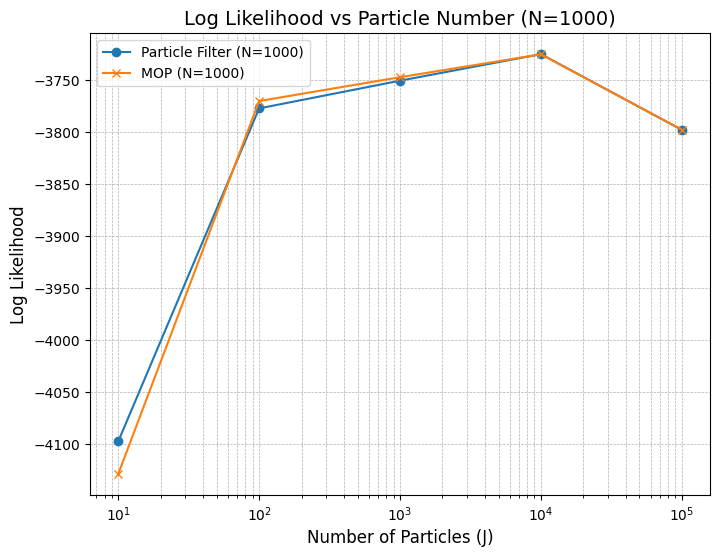

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(J_values, pf_loglik_1000, label='Particle Filter (N=1000)', marker='o')
plt.plot(J_values, mop_loglik_1000, label='MOP (N=1000)', marker='x')
plt.xscale('log')
plt.xlabel('Number of Particles (J)', fontsize=12)
plt.ylabel('Log Likelihood', fontsize=12)
plt.title('Log Likelihood vs Particle Number (N=1000)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

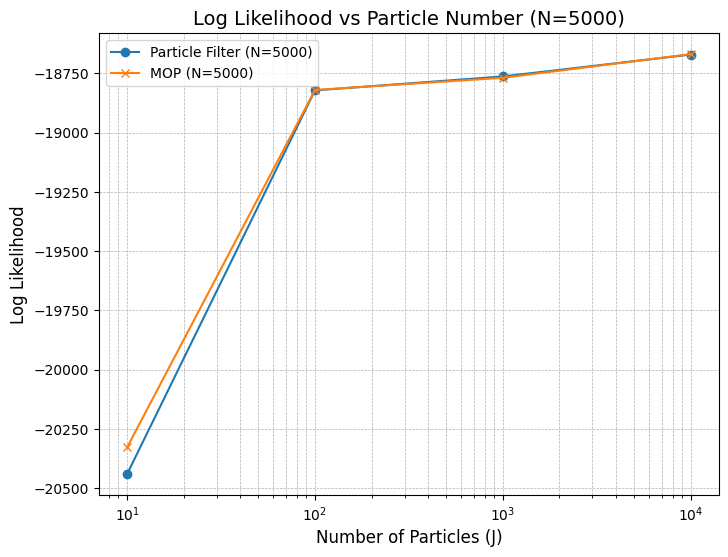

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(J_values_5000, pf_loglik_5000, label='Particle Filter (N=5000)', marker='o')
plt.plot(J_values_5000, mop_loglik_5000, label='MOP (N=5000)', marker='x')
plt.xscale('log')
plt.xlabel('Number of Particles (J)', fontsize=12)
plt.ylabel('Log Likelihood', fontsize=12)
plt.title('Log Likelihood vs Particle Number (N=5000)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

### Runtime vs. Particle Number J for Particle Filter and MOP (N=1000, 5000)

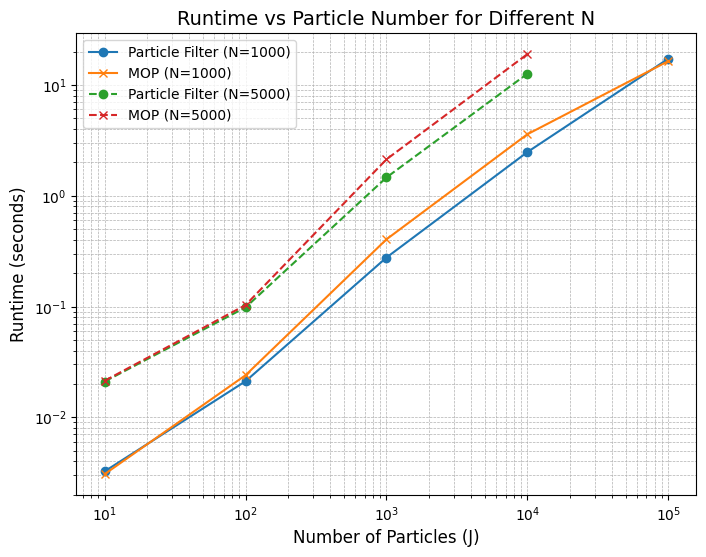

In [36]:

plt.figure(figsize=(8, 6))
plt.plot(J_values, time_pf_1000, label='Particle Filter (N=1000)', marker='o')
plt.plot(J_values, time_mop_1000, label='MOP (N=1000)', marker='x')
plt.plot(J_values_5000, time_pf_5000, label='Particle Filter (N=5000)', marker='o', linestyle='--')
plt.plot(J_values_5000, time_mop_5000, label='MOP (N=5000)', marker='x', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Particles (J)', fontsize=12)
plt.ylabel('Runtime (seconds)', fontsize=12)
plt.title('Runtime vs Particle Number for Different N', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

memory requirement scales (J,N) for autodiff? - How much RAM we use


### Comparison with R-POMP

In [ ]:
# Set the number of replications to be 50 and run pypomp pfilter:


In [ ]:
# get the results from r-pomp pfilter with number of replications also equal 50

In [ ]:
# Run the T-test

### Comparison of the negative loglikelihood distribution of pfilter on Pypomp and Rpomp when J is small.

100%|██████████| 100/100 [00:00<00:00, 862.27it/s]


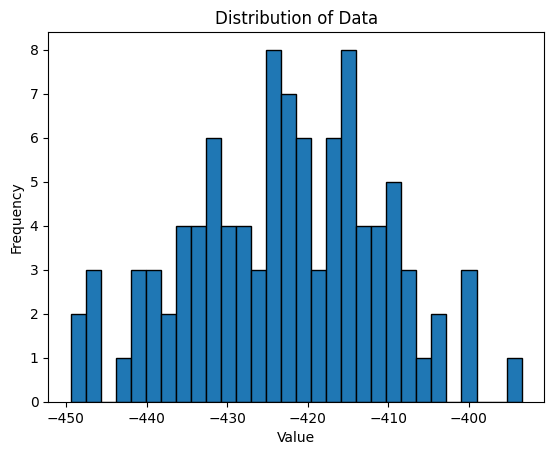

In [16]:
# set J = 10
# pypomp:
J = 10
nrep = 100
pypf_loglik_arr = []
xs, ys, key = generate_data(100, key)
for i in range(nrep):
    key, subkey = jax.random.split(key)
    pf_val = -pfilter(J = J, rinit = rinit, rprocess = rprocess, dmeasure = dmeasure, theta = theta, ys = ys, thresh = 2, key=subkey)
    pypf_loglik_arr.append(pf_val)
    
plt.hist(pypf_loglik_arr, bins=30, edgecolor='black')
plt.title("Distribution of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [17]:
 pypf_loglik_arr

[Array(-425.08713, dtype=float32),
 Array(-414.2515, dtype=float32),
 Array(-449.40982, dtype=float32),
 Array(-408.9693, dtype=float32),
 Array(-413.19974, dtype=float32),
 Array(-411.05826, dtype=float32),
 Array(-421.0837, dtype=float32),
 Array(-423.7222, dtype=float32),
 Array(-429.2598, dtype=float32),
 Array(-419.5613, dtype=float32),
 Array(-420.9491, dtype=float32),
 Array(-416.8744, dtype=float32),
 Array(-399.89084, dtype=float32),
 Array(-413.26917, dtype=float32),
 Array(-427.41995, dtype=float32),
 Array(-421.40195, dtype=float32),
 Array(-408.03687, dtype=float32),
 Array(-422.5786, dtype=float32),
 Array(-447.93457, dtype=float32),
 Array(-431.33908, dtype=float32),
 Array(-399.13904, dtype=float32),
 Array(-433.37637, dtype=float32),
 Array(-430.5116, dtype=float32),
 Array(-403.06058, dtype=float32),
 Array(-438.38547, dtype=float32),
 Array(-406.90375, dtype=float32),
 Array(-440.67407, dtype=float32),
 Array(-409.97363, dtype=float32),
 Array(-434.51083, dtype=float

In [18]:
ys

Array([[ 3.1143219e+00,  1.9836423e+00],
       [-6.8095857e-01, -1.0164718e-01],
       [ 1.8233198e-01,  6.3972604e-01],
       [-9.9336302e-01, -4.3228498e+00],
       [-7.3091280e-01, -2.1737654e+00],
       [ 1.3665850e+00, -1.0407975e+00],
       [-1.3386478e+00, -4.3150783e-01],
       [ 4.3532261e-01,  1.2003580e+00],
       [-1.4988774e-01,  1.8556015e+00],
       [-2.4418636e-01,  2.7372265e+00],
       [ 1.6783786e+00,  1.0905340e+00],
       [ 2.9096675e+00,  3.2433777e+00],
       [ 7.5866210e-01,  1.4518139e+00],
       [-2.7965951e+00,  2.1088641e+00],
       [-3.7651963e+00,  3.6855509e+00],
       [-3.1218705e+00,  3.1246681e+00],
       [-3.0742674e+00,  1.5390306e+00],
       [-2.4248788e+00,  2.4848328e+00],
       [-5.3994703e+00,  1.1039070e+00],
       [-5.8279018e+00, -1.7817116e+00],
       [-5.2495909e+00, -7.5420737e-01],
       [-3.2234745e+00,  7.1547508e-02],
       [-3.4210861e+00, -3.7794805e+00],
       [-6.3464980e+00, -1.3355021e+00],
       [-3.42229

### Convergence Analysis of Log Likelihood for Particle Filter (N=1000, 5000)